In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('once')

In [15]:
serie = pd.read_csv('data/serie_Demanda_Electrica_UE.csv', index_col=0, parse_dates=True)
serie.head()

,demand_EU
Date,
1979-01-01,9355907.3
1979-01-02,10725478.9
1979-01-03,11054636.7
1979-01-04,11051132.3
1979-01-05,10851689.6


In [3]:
serie.index  # ya está en formato Datetime ( gracias Lidia del pasado tq <3 )

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=16802, freq=None)

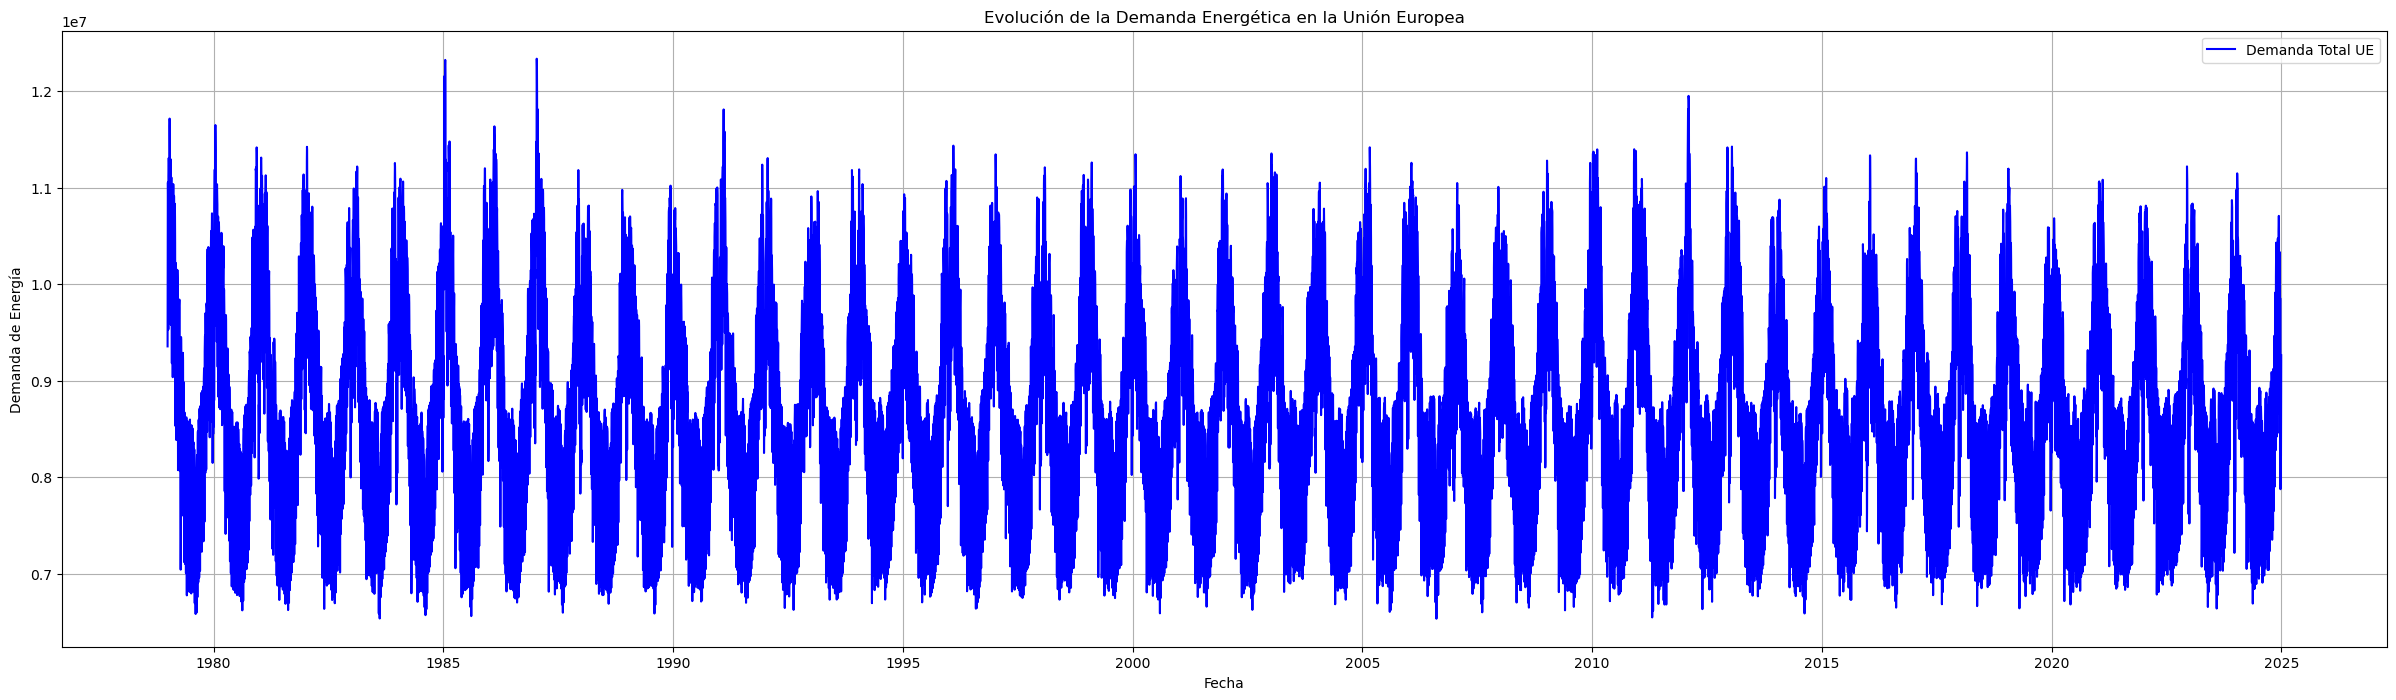

In [4]:
# Crear la figura y el gráfico
plt.figure(figsize=(30, 8))
plt.plot(serie.index, serie.values, label="Demanda Total UE", color="blue")

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.title("Evolución de la Demanda Energética en la Unión Europea")
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

## Entrenamiento 1: datos reducidos 2019 - 2024
Para que el entrenamiento sea más rápido, se tomarán solamente los datos de entrenamiento de 2019 a 2024

In [5]:
from pmdarima import auto_arima

In [6]:
# datos de 2019 a 2024
serie_red = serie['2019':'2024']


train_size = int(len(serie_red) * 0.8)
train, test = serie_red[0:train_size], serie_red[train_size:]

### Descomposición serie prueba

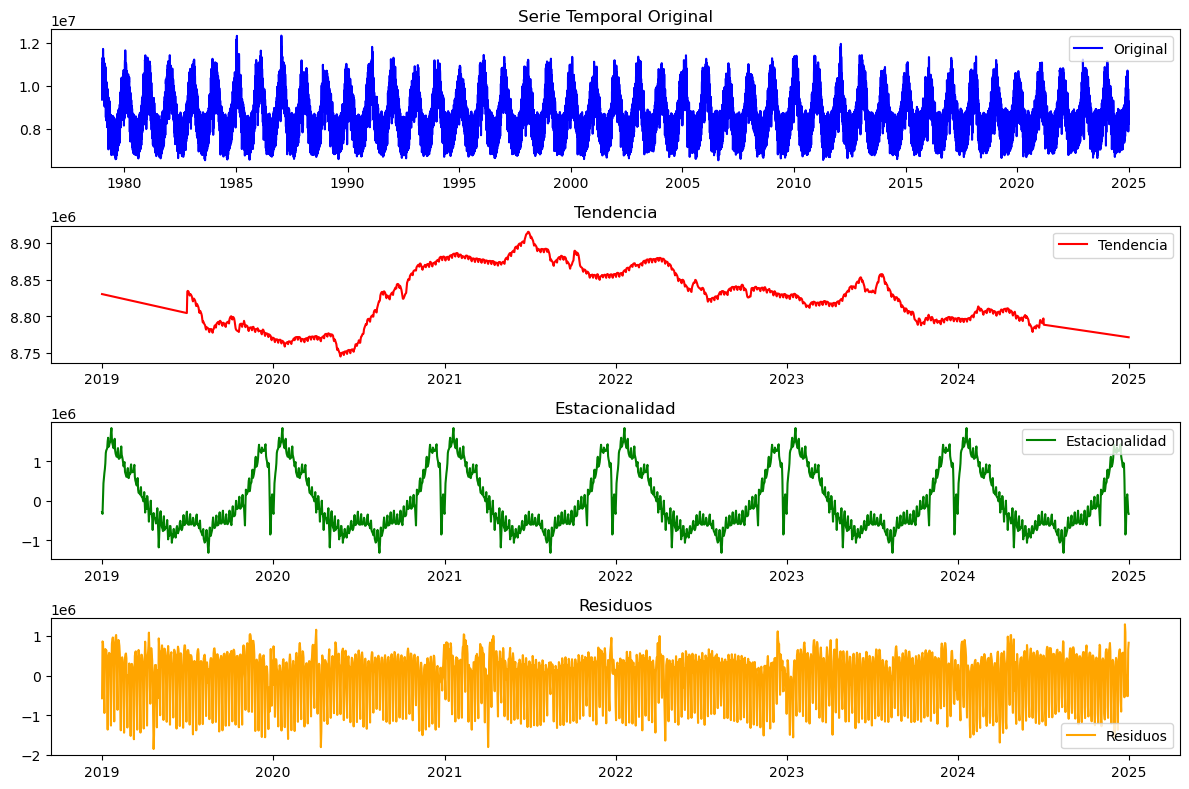

In [7]:
# ESTACIONALIDAD anual
PERIODO_ANUAL = 365

serie_descomp = seasonal_decompose(serie_red, model='additive', extrapolate_trend='freq', period=PERIODO_ANUAL)

# Obtención de las componentes
trend = serie_descomp.trend
seasonal = serie_descomp.seasonal
residuals = serie_descomp.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(serie, label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

### Estacionariedad serie ```d = 0```


In [11]:
from pmdarima.arima.utils import ndiffs

# Calcular el número óptimo de diferenciaciones con el test de KPSS
d_optimo = ndiffs(serie_red, test='kpss')
print(f"Valor óptimo de d según KPSS: {d_optimo}")

Valor óptimo de d según KPSS: 0


Test de Dickey-Fuller aumentado (ADF) para la serie temporal, en el que se verifica la estacionariedad mediante el contraste de raíz unitaria: 
- $H_0$ : existe una raíz unitaria, por lo tanto la serie temporal no es estacionaria.
- $H_1$ : no existe una raíz unitaria, por lo tanto la serie temporal es estacionaria.

In [12]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller Aumentado
result_adfuller = adfuller(serie_red)

# Mostrar resultados
print(f"Estadístico de prueba ADF: {result[0]}")
print(f"p-valor: {result[1]}")

# Ver si la serie es estacionaria
if result_adfuller[1] < 0.05:
    print("La serie es estacionaria (no necesita diferenciación, d=0).")
else:
    print("La serie no es estacionaria (se recomienda diferenciación, d=1).")

Estadístico de prueba ADF: -3.721594200080635
p-valor: 0.0038194639075604412
La serie es estacionaria (no necesita diferenciación, d=0).


Los resultados del test de Dickey-Fuller aumentado (ADF) para la serie temporal son los siguientes:  
p-valor $= 0.0038$ $< 0.05$, por lo que se rechaza la hipótesis nula $H_0$ y se concluye que la serie temporal es estacionaria.

### ARIMA

Proceso de ajuste de un modelo ARIMA (método de Box-Jenkins) para la serie temporal:
      
1. **Comprobar si la serie es estacionaria**   
    (y en caso de que no lo sea, estacionarizarla -Box-Cox-)
      
2. **Estimación de los parámtros del modelo ARIMA**
    - usar como criterio de selección el AIC (Akaike Information Criterion)
    - usar como criterio de selección el BIC (Bayesian Information Criterion)
      
3) **Diagnóstico del modelo**
    - Análisis de los residuos
    - Test de Ljung-Box para los residuos
    - Test de media cero para los residuos
    - Test de normalidad para los residuos
    - Test de homocedasticidad para los residuos
      
      


#### Prueba 1

- ```seasonal = False``` : la serie temporal no tiene estacionalidad.
- ```stepwise = True``` :  búsqueda heurística para reducir cómputo.
- ```n_jobs = -1``` : usa todos los núcleos de la CPU disponibles.
- ```scoring = 'mae'``` : métrica de evaluación de la calidad del modelo, en lugar de ```information_criterion```.
- ```stationary = True``` : la serie temporal es estacionaria.
- ```supress_warnings = True``` : no muestra advertencias.
- ```trace = True``` : imprime información sobre cada modelo evaluado.

In [9]:
# Establecer la frecuencia de los datos (diaria)
frequency = 'D'  

# Definir el rango de hiperparámetros para ARIMA (sin estacionalidad)
start_p = 0
d = 0  # serie estacionaria
start_q = 0
max_p = 5  # Se amplía para explorar más opciones
max_d = 0  
max_q = 5  # Se amplía para más flexibilidad

# Ajuste del modelo con auto_arima sin estacionalidad
arima_1 = auto_arima(
    serie_red, 
    seasonal=False,  # No queremos estacionalidad en esta primera prueba
    start_p=start_p, d=d, start_q=start_q, 
    max_p=max_p, max_d=max_d, max_q=max_q, 
    stepwise=True,  # búsqueda rápida
    information_criterion='aic',
    stationary=True,  # sabemos que la serie es estacionaria
    suppress_warnings=True, 
    trace=True, 
    
)

# Imprimir los mejores hiperparámetros encontrados por auto_arima
print("Mejores hiperparámetros ARIMA:", arima_1.get_params())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=76365.884, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=74732.194, Time=1.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=65174.869, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=64910.922, Time=3.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=64331.144, Time=7.78 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=64707.069, Time=5.97 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=9.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=64265.150, Time=6.71 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=64276.903, Time=1.41 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=64179.739, Time=10.97 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=64303.599, Time=5.20 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=

````scoring```` → Se usa para seleccionar el mejor modelo cuando se usa validación cruzada, si queremos evaluar modelos basándonos en su desempeño en datos fuera de muestra.   
  
````information_criterion```` → Se usa para comparar modelos sin validación cruzada y encontrar el que mejor equilibra ajuste y complejidad. Cuando buscamos el mejor modelo dentro de la serie temporal sin particionar datos.   

In [8]:
# Establecer la frecuencia de los datos (diaria)
frequency = 'D'  

# Definir el rango de hiperparámetros para ARIMA (sin estacionalidad)
start_p = 0
d = 0  # OPTIMIZADO
start_q = 0
max_p = 5  # Se amplía para explorar más opciones
max_d = 0  
max_q = 5  # Se amplía para más flexibilidad

# Ajuste del modelo con auto_arima sin estacionalidad
arima_2 = auto_arima(
    serie_red, 
    seasonal=False,  # No estacionalidad
    start_p=start_p, d=d, start_q=start_q, 
    max_p=max_p, max_d=max_d, max_q=max_q, 
    stepwise=False,  # examinar todas las posibles combinaciones
    suppress_warnings=True, 
    trace=True, 
    information_criterion='aic',  # el Criterio de información de Akaike es más adecuado
    n_jobs=-1,  # para paralelizar el proceso
    trend=None  # permitir que el modelo determine la tendencia
)

# Imprimir los mejores hiperparámetros encontrados por auto_arima
print("Mejores hiperparámetros ARIMA:", arima_2.get_params())


Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 181.394 seconds
Mejores hiperparámetros ARIMA: {'maxiter': 50, 'method': 'lbfgs', 'order': (2, 0, 3), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


### SARIMA

In [13]:
# Establecer la frecuencia de los datos (por ejemplo, 'D' para diario, 'M' para mensual, 'Y' para anual)
frequency = 'D'  # datos diarios

# Definir el número de períodos en una temporada (ajustar según sea necesario)
seasonal_periods = 365  # datos son diarios con estacionalidad anual


# Definir el rango de hiperparámetros
start_p, start_q, start_P, start_Q = 0, 0, 0, 0
d, D = 0, 1  # d=0 porque la serie es estacionaria, D=1 para capturar estacionalidad
max_p, max_q, max_P, max_Q = 5, 5, 3, 3  
max_d, max_D = 0, 1  # idem


# Utilizar auto_arima para buscar automáticamente los mejores hiperparámetros minimizando el MAE
sarima_1 = auto_arima(
    serie_red, 
    seasonal=True,  # Activar estacionalidad
    m=seasonal_periods,  # Periodo estacional de 365 días
    start_p=start_p, d=d, start_q=start_q, start_P=start_P, D=D, start_Q=start_Q, 
    max_p=max_p, max_d=max_d, max_q=max_q, max_P=max_P, max_D=max_D, max_Q=max_Q, 
    stepwise=True,
    n_jobs=-1,  # Usa múltiples núcleos para acelerar
    information_criterion='aic',  # Selección basada en AIC
    suppress_warnings=True, 
    #trace=True  # Mostrar el proceso de búsqueda
)


# Imprimir los mejores hiperparámetros encontrados por auto_arima
print("Mejores hiperparámetros SARIMA:", sarima_1.get_params())

c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


MemoryError: Unable to allocate 2.19 GiB for an array with shape (366, 366, 2193) and data type float64

In [ ]:
# Establecer la frecuencia de los datos (por ejemplo, 'D' para diario, 'M' para mensual, 'Y' para anual)
frequency = 'D'  # datos diarios

# Definir el número de períodos en una temporada (ajustar según sea necesario)
seasonal_periods = 365  # datos son diarios con estacionalidad anual


# Definir el rango de hiperparámetros
start_p, start_q, start_P, start_Q = 0, 0, 0, 0
d, D = 0, 1  # d=0 porque la serie es estacionaria, D=1 para capturar estacionalidad
max_p, max_q, max_P, max_Q = 5, 5, 3, 3  
max_d, max_D = 0, 1  # idem


# Utilizar auto_arima para buscar automáticamente los mejores hiperparámetros minimizando el MAE
sarima_1 = auto_arima(
    serie_red, 
    seasonal=True,  # Activar estacionalidad
    m=seasonal_periods,  # Periodo estacional de 365 días
    start_p=start_p, d=d, start_q=start_q, 
    start_P=start_P, D=D, start_Q=start_Q, 
    max_p=max_p, max_d=max_d, max_q=max_q, 
    max_P=max_P, max_D=max_D, max_Q=max_Q, 
    stepwise=False,
    n_jobs=-1,  # Usa múltiples núcleos para acelerar
    information_criterion='aic',  # Selección basada en AIC
    suppress_warnings=True, 
    #trace=True  # Mostrar el proceso de búsqueda
)


# Imprimir los mejores hiperparámetros encontrados por auto_arima
print("Mejores hiperparámetros SARIMA:", sarima_1.get_params())